Code inspired of
https://github.com/Mehran970/Real-Time-Traffic-Sign-Detection

In [2]:
import warnings
import numpy as np
import os, random
import tensorflow as tf
import cv2
import sys
import argparse
from imutils.video import VideoStream
import time
from scipy import ndimage
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
from skimage import transform

# a different model can be taken from the github
model = "ssd_mobilenet_v1"

In [3]:
def ts_detection (frame, sess, boxes, scores, classes, num_detections):

    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # TODO
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image, axis=0)
    # Actual detection
    (boxes, scores, classes, num_detections) = sess.run(
        [boxes, scores, classes, num_detections],
        feed_dict={image_tensor: image_np_expanded})
    # bounding boxes
    idxs = cv2.dnn.NMSBoxes(boxes, scores, 0.5, 1.5)

    return  idxs, boxes, scores, classes

In [4]:
'''%tb
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# construct the argument parse and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-w", "--webcam", type=int, default="0",
    help="index of webcam on system")
ap.add_argument("-m", "--models", default="models",
    help="base path to model directory")
ap.add_argument("-mn", "--model_name", default="ssd_mobilenet_v1",
    help="name of model detection")

args = vars(ap.parse_args())
'''

# Initialization for detection objects
# Append Tensorflow object detection and darkflow directories to path
sys.path.append('PATH_TO_TENSORFLOW_OBJECT_DETECTION_FOLDER')  # ~/tensorflow/models/research/object_detection
# sys.path.append('PATH_TO_DARKFLOW_FOLDER') # ~/darkflow

# we import modules from the Tensorflow ObjectDetection API 
# https://github.com/tensorflow/models/tree/master/research/object_detection

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

# Loading model
#MODEL_PATH = os.path.join(args["models"], args["model_name"])
MODEL_PATH = os.path.join("DetectionModel",model)

# Path to frozen detection graph. This is the actual model that is used for the traffic sign detection.
PATH_TO_CKPT = os.path.join(MODEL_PATH, 'inference_graph/frozen_inference_graph.pb')

# Loading list of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join("", "label_map.pbtxt")
# Loading label map
# Label maps map indices to category names, so that when our convolution network predicts `2`,
# we know that this corresponds to `mandatory`.

NUM_CLASSES = 3
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES,
                                                                use_display_name=True)
category_index = label_map_util.create_category_index(categories)
COLORS=[(255,0,0), (0,0,255), (0,255,0), (128,255,255)]

In [5]:
# Load a (frozen) Tensorflow model into memory
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.compat.v1.GraphDef()
    with tf.io.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

# Each box represents a part of the image where a particular object was detected.
boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

# Each score represent how level of confidence for each of the objects.
# Score is shown on the result image, together with the class label.
scores = detection_graph.get_tensor_by_name('detection_scores:0')

classes = detection_graph.get_tensor_by_name('detection_classes:0')

num_detections = detection_graph.get_tensor_by_name('num_detections:0')

sess = tf.compat.v1.Session(graph=detection_graph)

Detection process with the graph

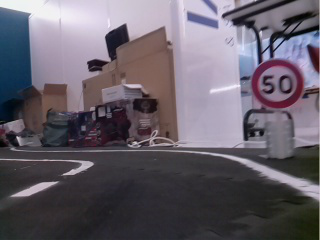

Confidence for the bounding box :  98 %


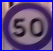

True

In [6]:
path_to_image = '../TrafficSignImages/image_1625758655.6851828.jpg'

# We display the original image
j = plt.imread(path_to_image)
j = (Image.fromarray(j,'RGB'))
j.show()


frame = cv2.imread(path_to_image)
(height, width, _) = frame.shape
idxs, BOXES, SCORES, CLASSES = ts_detection(frame, sess, boxes, scores, classes, num_detections)

'''print("indexes : ",idxs)
print("Boxes : ", BOXES)
print("Scores : ", SCORES)
print("Classes : ", CLASSES)
'''  

    
if len(idxs) > 0:
    # loop over the indexes we are keeping
    for i in idxs.flatten():
            # extract the bounding box coordinates
        ymin = int((BOXES[0][i][0] * height))
        xmin = int((BOXES[0][i][1] * width))
        ymax = int((BOXES[0][i][2] * height))
        xmax = int((BOXES[0][i][3] * width))

        
        LABEL = category_index[int(CLASSES[0][i])]
        SCORE = int(SCORES[0][i] * 100)
        if SCORE > 85:
            print("Confidence for the bounding box : ",SCORE,"%")
            cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), COLORS[int(LABEL['id'])], 2)
            y = ymin - 10 if ymin - 10 > 10 else ymin + 10
            cv2.putText(frame, str(LABEL['name']) + ": %" + str(SCORE), (xmin, y),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, COLORS[int(LABEL['id'])], 2)
            cropped_image = np.array(frame)
            cropped_image = cropped_image[ymin:ymax,xmin:xmax,:]
            # We keep only the interior of the bounding box
            im = (Image.fromarray(cropped_image,'RGB'))
            im.show()
            im.save("ess50_cropped.jpg")

# We save the picture with the bounding box and the label
cv2.imwrite('ess50.jpg',frame)

Here we will convert the Tensorflow Frozen graph into a TFLite model

In [ ]:
input_arrays=["image_tensor"]
output_arrays=["detection_boxes","detection_scores","num_detections","detection_classes"]
input_tensor={"image_tensor":[1,240,320,3]}
#input_shape = [1,240,320,3]
converter = tf.compat.v1.lite.TFLiteConverter.from_frozen_graph(PATH_TO_CKPT, input_arrays, output_arrays)#, input_tensor)

converter.experimental_new_converter = True
converter.allow_custom_ops = True
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,tf.lite.OpsSet.SELECT_TF_OPS]

# Load the TFLite model and allocate tensors.
tflite_model = converter.convert()
with open('DetectionModel/model.tflite', 'wb') as f:
  f.write(tflite_model)

Still not working, while invoking the interpreter, the kernel crashes

In [ ]:
path_to_image = '../TrafficSignImages/image_1625758655.6851828.jpg'
frame = cv2.imread(path_to_image)
frame = frame.astype('uint8')
frame = np.reshape(frame, (-1,240,320,3))


interpreter = tf.lite.Interpreter(model_path='DetectionModel/model.tflite')

# we resize the input tensor to the desired values (the camera width and height) since the current value
# is [1,1,1,3] it can be seen by calling interpreter.get_input_details()[0] before this
interpreter.resize_tensor_input(0,[1,240,320,3]) 
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data.
input_shape = input_details[0]['shape']

frame = frame.astype('uint8')
frame = np.reshape(frame, (-1,240,320,3))


interpreter.set_tensor(input_details[0]['index'], frame)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

Label Overview for the recognition part

In [7]:
sign_classes = {
            0:'Speed limit (30km/h)', 
            1:'Speed limit (50km/h)',  
            2:'No passing', 
            3:'Stop', 
            4:'No entry', 
 }

Example of recognition on a desired image (must be "well" framed)

In [12]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="../RecognitionModel/model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data.
input_shape = input_details[0]['shape']
#input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)

#im = np.array(im.getdata()).reshape(im.size[0], im.size[1], 3)
img = plt.imread("SSD_Mobilenet_results/ess30_cropped.jpg")
img = transform.resize(img,(30,30))
img = img.astype('float32')
img = np.reshape(img, (-1,30,30,3))

interpreter.set_tensor(input_details[0]['index'], img)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])
prediction = output_data[0]
label = np.argmax(prediction)
proba = np.max(prediction)
print("The predicted sign is", sign_classes[np.argmax(prediction)]," with ", str(np.round(proba*100,2)),"% confidence")
print(prediction)

cv2.imwrite('SSD_Mobilenet_results/ess30_cropped.jpg',frame)



The predicted sign is Speed limit (30km/h)  with  99.48 % confidence
[9.9478227e-01 4.8989020e-03 2.9215164e-04 7.4125114e-06 1.9033683e-05]


True

Whole process with the Tensorflow graph

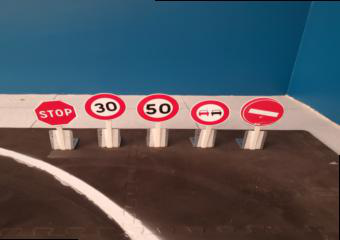

Confidence for the bounding box :  99 %


The predicted sign is Speed limit (50km/h)  with  100.0 % confidence
Confidence for the bounding box :  99 %


The predicted sign is Speed limit (30km/h)  with  99.99 % confidence
Confidence for the bounding box :  97 %


The predicted sign is No passing  with  99.99 % confidence

Total time :  0.0473 s


In [41]:
#path_to_image = '../TrafficSignImages/image_1625758655.5502768.jpg'
path_to_image = '../RapportStage/TrafficSignsMIA_resized.jpg'

#file = random.choice(os.listdir("../Data/ImagesPS4/"))  #select randomly a file
#path_to_image = os.path.join('../Data/ImagesPS4/',file)

j = plt.imread(path_to_image)
j = (Image.fromarray(j,'RGB'))
j.show()


tps1 = time.time()
frame = cv2.imread(path_to_image)
(height, width, _) = frame.shape
idxs, BOXES, SCORES, CLASSES = ts_detection(frame, sess, boxes, scores, classes, num_detections)

# idxs gives the number of bounding boxes (number of traffic sign detected)
# BOXES gives the coordinates for each sign detected
# SCORES gives the confidence for each bounding box prediction
# CLASSES gives the class (mandatory, prohibitory or danger) for each sign

'''print("indexes : ",idxs)
print("Boxes : ", BOXES)
print("Scores : ", SCORES)
print("Classes : ", CLASSES)
'''  
    
if len(idxs) > 0:
    # loop over the indexes we are keeping
    for i in idxs.flatten():
        # extract the bounding box coordinates
        ymin = int((BOXES[0][i][0] * height))
        xmin = int((BOXES[0][i][1] * width))
        ymax = int((BOXES[0][i][2] * height))
        xmax = int((BOXES[0][i][3] * width))

        
        LABEL = category_index[int(CLASSES[0][i])]
        SCORE = int(SCORES[0][i] * 100)
        
        # if the confidence score for a bounding box is greater than 85, we run the below code
        if SCORE > 85:
            print("Confidence for the bounding box : ",SCORE,"%")
            cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), COLORS[int(LABEL['id'])], 2)
            y = ymin - 10 if ymin - 10 > 10 else ymin + 10
            cv2.putText(frame, str(LABEL['name']) + ": %" + str(SCORE), (xmin, y),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, COLORS[int(LABEL['id'])], 2)
            cropped_image = np.array(frame)
            
            cropped_image = cropped_image[ymin:ymax,xmin:xmax,:]
            im = (Image.fromarray(cropped_image,'RGB'))
            im.show()
            

            # Load the TFLite model and allocate tensors for the recognition
            interpreter_recognition = tf.lite.Interpreter(model_path="../RecognitionModel/model.tflite")
            interpreter_recognition.allocate_tensors()

            input_details_recognition = interpreter_recognition.get_input_details()
            output_details_recognition = interpreter_recognition.get_output_details()

            input_shape_recognition = input_details_recognition[0]['shape']


            img = transform.resize(cropped_image,(30,30))
            img = img.astype('float32')
            img = np.reshape(img, (-1,30,30,3))

            interpreter_recognition.set_tensor(input_details_recognition[0]['index'], img)
            interpreter_recognition.invoke()
            output_data_recognition = interpreter_recognition.get_tensor(output_details[0]['index'])
            prediction_recognition = output_data_recognition[0]
            label_recognition = np.argmax(prediction_recognition)
            proba_recognition = np.max(prediction_recognition)
            print("The predicted sign is", sign_classes[np.argmax(prediction_recognition)]," with ", str(np.round(proba_recognition*100,2)),"% confidence\n\n")


tps2 = time.time()
print("\nTotal time : ",np.round(tps2-tps1,4),"s")